<a href="https://colab.research.google.com/github/robonesky/oreilly/blob/main/RM%20Lab%20Notes%2012%20202301%20cohort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=ae31cd4f0da22673fbe022c05a7c7f688e80e454d6ab4a428ac772d9ebafaad7
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)

np.random.seed(42)

dow = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')

dow

[                                                   0                                                  1
 0  Historical logarithmic graph of the DJIA from ...  Historical logarithmic graph of the DJIA from ...
 1                                         Foundation  February 16, 1885; 138 years ago[1] May 26, 18...
 2                                           Operator                              S&P Dow Jones Indices
 3                                          Exchanges  .mw-parser-output .plainlist ol,.mw-parser-out...
 4                                     Trading symbol                                  ^DJI$INDU.DJIDJIA
 5                                       Constituents                                                 30
 6                                               Type                                          Large cap
 7                                         Market cap           US$10.9 trillion (as of May 31, 2023)[3]
 8                                   Weighting method  

In [4]:
# the components table is the 2nd table:

dow[1]

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,2.41%
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,3.02%
2,Amgen,NASDAQ,AMGN,Biopharmaceutical,2020-08-31,NaN,5.48%
3,Apple,NASDAQ,AAPL,Information technology,2015-03-19,NaN,2.84%
4,Boeing,NYSE,BA,Aerospace and defense,1987-03-12,NaN,3.36%
5,Caterpillar,NYSE,CAT,Construction and Mining,1991-05-06,NaN,4.52%
6,Chevron,NYSE,CVX,Petroleum industry,2008-02-19,Also 1930-07-18 to 1999-11-01,3.50%
7,Cisco,NASDAQ,CSCO,Information technology,2009-06-08,NaN,0.96%
8,Coca-Cola,NYSE,KO,Drink industry,1987-03-12,Also 1932-05-26 to 1935-11-20,1.22%
9,Disney,NYSE,DIS,Broadcasting and entertainment,1991-05-06,NaN,1.89%


In [5]:
# Now get the list of stock symbols:
dow_stocks = list(dow[1]['Symbol'])
dow_company_name = list(dow[1]['Company'])
dow_stocks[:5]

['MMM', 'AXP', 'AMGN', 'AAPL', 'BA']

In [6]:
dow_company_name[:5]

['3M', 'American Express', 'Amgen', 'Apple', 'Boeing']

In [7]:
# If you wanted to download direct from yahoo finance:
######################################################

# Use comprehension to fetch data for multiple fields
dow_ohlc = {symbol: yf.download(symbol, start='2010-01-01', end='2022-05-31', auto_adjust=True, progress=False) for symbol in dow_stocks}

# Save dow_ohlc dict for future use
np.save('./dow_ohlc.npy', dow_ohlc)



In [8]:
# get the open close high low data:

ohlc = np.load('./dow_ohlc.npy', allow_pickle = True).item()
ohlc['MMM'].head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,55.903355,56.145565,55.620778,55.856258,3043700
2010-01-05,55.708248,55.997555,54.968159,55.506405,2847000
2010-01-06,56.434887,56.919307,56.185952,56.293598,5268500
2010-01-07,56.058120,56.354156,55.250756,56.333973,4470100
2010-01-08,56.307035,56.730900,56.044641,56.730900,3405800


In [9]:
for symbol in dow_stocks:
  high = ohlc[symbol]['High']
  low = ohlc[symbol]['Low']
  close = ohlc[symbol]['Close']

  # not entirely clear what 'atr' is - "Average true Range" it seems.  It's a volatility thing
  ohlc[symbol]['ATR'] = ta.atr(high, low, close)

In [10]:
ohlc['MMM'].head()

# We'll have to sort out these NaNs later

,Open,High,Low,Close,Volume,ATR
Date,,,,,,
2010-01-04,55.903355,56.145565,55.620778,55.856258,3043700,NaN
2010-01-05,55.708248,55.997555,54.968159,55.506405,2847000,NaN
2010-01-06,56.434887,56.919307,56.185952,56.293598,5268500,NaN
2010-01-07,56.058120,56.354156,55.250756,56.333973,4470100,NaN
2010-01-08,56.307035,56.730900,56.044641,56.730900,3405800,NaN


In [11]:
# returns

stock_price = pd.DataFrame(
    {symbol: ohlc[symbol]['Close']
    for symbol
    in dow_stocks}
)

stock_ret = stock_price.resample('W-FRI').last().pct_change()

stock_ret.head()



,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DOW,GS,HD,HON,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-15,-0.011267,0.010489,-0.009160,-0.028540,-0.012662,0.003152,-0.003020,-0.010543,0.020671,-0.040151,NaN,-0.052205,-0.014148,0.012108,0.007108,-0.001440,0.005451,-0.022382,0.007115,0.046950,0.006523,-0.020237,0.006287,-0.074444,0.004736,0.032110,-0.036850,-0.009886,-0.010544,0.006563
2010-01-22,-0.022670,-0.089644,0.006222,-0.039723,-0.050148,-0.097638,-0.058564,-0.058607,-0.036418,-0.020262,NaN,-0.067127,-0.029751,-0.064508,-0.047655,-0.042789,-0.021066,-0.103480,0.017823,-0.015201,-0.061569,-0.021898,-0.001266,-0.059595,-0.009838,-0.017481,-0.007849,-0.039586,-0.016667,-0.013785
2010-01-29,-0.012150,-0.024099,0.033215,-0.028773,0.048987,-0.037051,-0.033114,-0.021768,0.000184,-0.014343,NaN,-0.035037,0.010462,-0.031094,-0.024781,-0.025615,-0.005380,-0.005618,-0.015144,-0.017752,-0.026933,0.012226,0.020561,-0.015339,0.048851,-0.004825,-0.030323,-0.008461,0.001667,0.009256
2010-02-05,-0.024226,0.005045,-0.013680,0.017703,-0.029724,-0.009380,-0.013034,0.054740,-0.021383,-0.000338,NaN,0.036578,-0.001071,-0.030279,0.009233,0.011637,-0.003500,-0.016435,0.015057,-0.037978,-0.005678,-0.032156,-0.004062,-0.023131,-0.007697,-0.013939,-0.023114,0.006461,-0.076006,0.000374


In [12]:
stock_ret.isnull().sum()

MMM       1
AXP       1
AMGN      1
AAPL      1
BA        1
CAT       1
CVX       1
CSCO      1
KO        1
DIS       1
DOW     481
GS        1
HD        1
HON       1
IBM       1
INTC      1
JNJ       1
JPM       1
MCD       1
MRK       1
MSFT      1
NKE       1
PG        1
CRM       1
TRV       1
UNH       1
VZ        1
V         1
WBA       1
WMT       1
dtype: int64

In [13]:
# What's going on with all these nulls, particularly for DOW?
# Looks like there's a problem with one particular date
# (and strangely, it's a different date for me than for Kannan!)

[stock_ret[x].index[stock_ret[x].apply(np.isnan)] for x in dow_stocks]

[DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08', '2010-01-15', '2010-01-22', '2010-01-29', '2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05', '2010-03-12',
              

<Axes: xlabel='Date'>

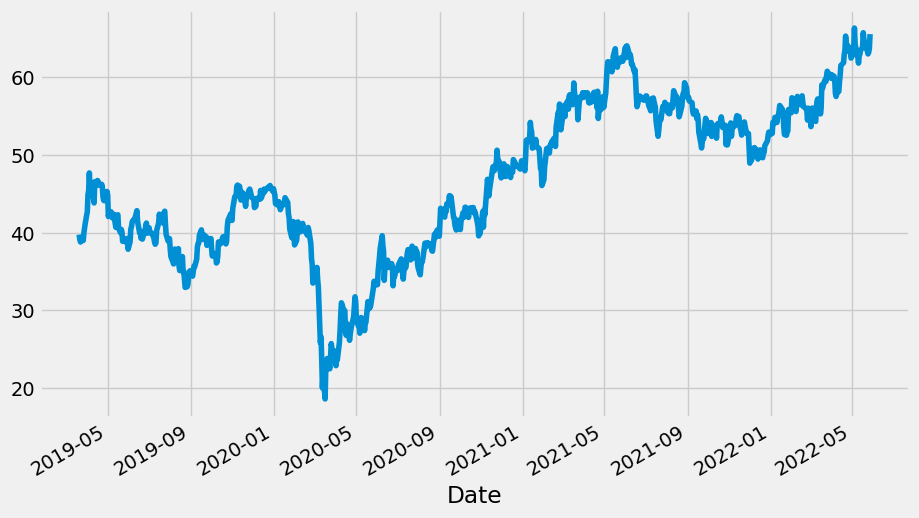

In [14]:
# That explains what's going on with the stocks with a single missing value, but what about
# DOW?

ohlc['DOW']['Close'].plot()

# We only have data since 2019, it seems, perhaps they changed the ticker or something

In [15]:
# Regardless.  Let's forward fill the other stocks, but drop DOW in its entirety

stock_ret.fillna(method='ffill', axis=0, inplace = True)
stock_ret.drop(['DOW'], axis = 1, inplace = True)
# stock_ret.dropna(inplace=True)

In [16]:
stock_ret.shape

(647, 29)

In [17]:
np.isnan(stock_ret.any()).sum() # what's the diference between isnull().sum()?

0

In [18]:
# weekly returns

weekly_ret = stock_ret.T
weekly_ret

Date,2010-01-08,2010-01-15,2010-01-22,2010-01-29,2010-02-05,2010-02-12,2010-02-19,2010-02-26,2010-03-05,2010-03-12,2010-03-19,2010-03-26,2010-04-02,2010-04-09,2010-04-16,2010-04-23,2010-04-30,2010-05-07,2010-05-14,2010-05-21,2010-05-28,2010-06-04,2010-06-11,2010-06-18,2010-06-25,2010-07-02,2010-07-09,2010-07-16,2010-07-23,2010-07-30,2010-08-06,2010-08-13,2010-08-20,2010-08-27,2010-09-03,2010-09-10,2010-09-17,2010-09-24,2010-10-01,2010-10-08,2010-10-15,2010-10-22,2010-10-29,2010-11-05,2010-11-12,2010-11-19,2010-11-26,2010-12-03,2010-12-10,2010-12-17,2010-12-24,2010-12-31,2011-01-07,2011-01-14,2011-01-21,2011-01-28,2011-02-04,2011-02-11,2011-02-18,2011-02-25,2011-03-04,2011-03-11,2011-03-18,2011-03-25,2011-04-01,2011-04-08,2011-04-15,2011-04-22,2011-04-29,2011-05-06,2011-05-13,2011-05-20,2011-05-27,2011-06-03,2011-06-10,2011-06-17,2011-06-24,2011-07-01,2011-07-08,2011-07-15,2011-07-22,2011-07-29,2011-08-05,2011-08-12,2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,2011-09-23,2011-09-30,2011-10-07,2011-10-14,2011-10-21,2011-10-28,2011-11-04,2011-11-11,2011-11-18,2011-11-25,2011-12-02,2011-12-09,2011-12-16,2011-12-23,2011-12-30,2012-01-06,2012-01-13,2012-01-20,2012-01-27,2012-02-03,2012-02-10,2012-02-17,2012-02-24,2012-03-02,2012-03-09,2012-03-16,2012-03-23,2012-03-30,2012-04-06,2012-04-13,2012-04-20,2012-04-27,2012-05-04,2012-05-11,2012-05-18,2012-05-25,2012-06-01,2012-06-08,2012-06-15,2012-06-22,2012-06-29,2012-07-06,2012-07-13,2012-07-20,2012-07-27,2012-08-03,2012-08-10,2012-08-17,2012-08-24,2012-08-31,2012-09-07,2012-09-14,2012-09-21,2012-09-28,2012-10-05,2012-10-12,2012-10-19,2012-10-26,2012-11-02,2012-11-09,2012-11-16,2012-11-23,2012-11-30,2012-12-07,2012-12-14,2012-12-21,2012-12-28,2013-01-04,2013-01-11,2013-01-18,2013-01-25,2013-02-01,2013-02-08,2013-02-15,2013-02-22,2013-03-01,2013-03-08,2013-03-15,2013-03-22,2013-03-29,2013-04-05,2013-04-12,2013-04-19,2013-04-26,2013-05-03,2013-05-10,2013-05-17,2013-05-24,2013-05-31,2013-06-07,2013-06-14,2013-06-21,2013-06-28,2013-07-05,2013-07-12,2013-07-19,2013-07-26,2013-08-02,2013-08-09,2013-08-16,2013-08-23,2013-08-30,2013-09-06,2013-09-13,2013-09-20,2013-09-27,2013-10-04,2013-10-11,2013-10-18,2013-10-25,2013-11-01,2013-11-08,2013-11-15,2013-11-22,2013-11-29,2013-12-06,2013-12-13,2013-12-20,2013-12-27,2014-01-03,2014-01-10,2014-01-17,2014-01-24,2014-01-31,2014-02-07,2014-02-14,2014-02-21,2014-02-28,2014-03-07,2014-03-14,2014-03-21,2014-03-28,2014-04-04,2014-04-11,2014-04-18,2014-04-25,2014-05-02,2014-05-09,2014-05-16,2014-05-23,2014-05-30,2014-06-06,2014-06-13,2014-06-20,2014-06-27,2014-07-04,2014-07-11,2014-07-18,2014-07-25,2014-08-01,2014-08-08,2014-08-15,2014-08-22,2014-08-29,2014-09-05,2014-09-12,2014-09-19,2014-09-26,2014-10-03,2014-10-10,2014-10-17,2014-10-24,2014-10-31,2014-11-07,2014-11-14,2014-11-21,2014-11-28,2014-12-05,2014-12-12,2014-12-19,2014-12-26,2015-01-02,2015-01-09,2015-01-16,2015-01-23,2015-01-30,2015-02-06,2015-02-13,2015-02-20,2015-02-27,2015-03-06,2015-03-13,2015-03-20,2015-03-27,2015-04-03,2015-04-10,2015-04-17,2015-04-24,2015-05-01,2015-05-08,2015-05-15,2015-05-22,2015-05-29,2015-06-05,2015-06-12,2015-06-19,2015-06-26,2015-07-03,2015-07-10,2015-07-17,2015-07-24,2015-07-31,2015-08-07,2015-08-14,2015-08-21,2015-08-28,2015-09-04,2015-09-11,2015-09-18,2015-09-25,2015-10-02,2015-10-09,2015-10-16,2015-10-23,2015-10-30,2015-11-06,2015-11-13,2015-11-20,2015-11-27,2015-12-04,2015-12-11,2015-12-18,2015-12-25,2016-01-01,2016-01-08,2016-01-15,2016-01-22,2016-01-29,2016-02-05,2016-02-12,2016-02-19,2016-02-26,2016-03-04,2016-03-11,2016-03-18,2016-03-25,2016-04-01,2016-04-08,2016-04-15,2016-04-22,2016-04-29,2016-05-06,2016-05-13,2016-05-20,2016-05-27,2016-06-03,2016-06-10,2016-06-17,2016-06-24,2016-07-01,2016-07-08,2016-07-15,2016-07-22,2016-07-29,2016-08-05,2016-08-12,2016-08-19,2016-08-26,2016-09-02,2016-09-09,2016-09-16,2016-09-23,2016-09-30,2016-10-07,2016-10-14,2016-10-21,2016-10-28,2016-11-04,2016-11-11,2016-11-18,2016-11-25,2016-12-02,2016-12-09,2016-12-16,20

In [19]:
weekly_ret.describe()

Date,2010-01-08,2010-01-15,2010-01-22,2010-01-29,2010-02-05,2010-02-12,2010-02-19,2010-02-26,2010-03-05,2010-03-12,2010-03-19,2010-03-26,2010-04-02,2010-04-09,2010-04-16,2010-04-23,2010-04-30,2010-05-07,2010-05-14,2010-05-21,2010-05-28,2010-06-04,2010-06-11,2010-06-18,2010-06-25,2010-07-02,2010-07-09,2010-07-16,2010-07-23,2010-07-30,2010-08-06,2010-08-13,2010-08-20,2010-08-27,2010-09-03,2010-09-10,2010-09-17,2010-09-24,2010-10-01,2010-10-08,2010-10-15,2010-10-22,2010-10-29,2010-11-05,2010-11-12,2010-11-19,2010-11-26,2010-12-03,2010-12-10,2010-12-17,2010-12-24,2010-12-31,2011-01-07,2011-01-14,2011-01-21,2011-01-28,2011-02-04,2011-02-11,2011-02-18,2011-02-25,2011-03-04,2011-03-11,2011-03-18,2011-03-25,2011-04-01,2011-04-08,2011-04-15,2011-04-22,2011-04-29,2011-05-06,2011-05-13,2011-05-20,2011-05-27,2011-06-03,2011-06-10,2011-06-17,2011-06-24,2011-07-01,2011-07-08,2011-07-15,2011-07-22,2011-07-29,2011-08-05,2011-08-12,2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,2011-09-23,2011-09-30,2011-10-07,2011-10-14,2011-10-21,2011-10-28,2011-11-04,2011-11-11,2011-11-18,2011-11-25,2011-12-02,2011-12-09,2011-12-16,2011-12-23,2011-12-30,2012-01-06,2012-01-13,2012-01-20,2012-01-27,2012-02-03,2012-02-10,2012-02-17,2012-02-24,2012-03-02,2012-03-09,2012-03-16,2012-03-23,2012-03-30,2012-04-06,2012-04-13,2012-04-20,2012-04-27,2012-05-04,2012-05-11,2012-05-18,2012-05-25,2012-06-01,2012-06-08,2012-06-15,2012-06-22,2012-06-29,2012-07-06,2012-07-13,2012-07-20,2012-07-27,2012-08-03,2012-08-10,2012-08-17,2012-08-24,2012-08-31,2012-09-07,2012-09-14,2012-09-21,2012-09-28,2012-10-05,2012-10-12,2012-10-19,2012-10-26,2012-11-02,2012-11-09,2012-11-16,2012-11-23,2012-11-30,2012-12-07,2012-12-14,2012-12-21,2012-12-28,2013-01-04,2013-01-11,2013-01-18,2013-01-25,2013-02-01,2013-02-08,2013-02-15,2013-02-22,2013-03-01,2013-03-08,2013-03-15,2013-03-22,2013-03-29,2013-04-05,2013-04-12,2013-04-19,2013-04-26,2013-05-03,2013-05-10,2013-05-17,2013-05-24,2013-05-31,2013-06-07,2013-06-14,2013-06-21,2013-06-28,2013-07-05,2013-07-12,2013-07-19,2013-07-26,2013-08-02,2013-08-09,2013-08-16,2013-08-23,2013-08-30,2013-09-06,2013-09-13,2013-09-20,2013-09-27,2013-10-04,2013-10-11,2013-10-18,2013-10-25,2013-11-01,2013-11-08,2013-11-15,2013-11-22,2013-11-29,2013-12-06,2013-12-13,2013-12-20,2013-12-27,2014-01-03,2014-01-10,2014-01-17,2014-01-24,2014-01-31,2014-02-07,2014-02-14,2014-02-21,2014-02-28,2014-03-07,2014-03-14,2014-03-21,2014-03-28,2014-04-04,2014-04-11,2014-04-18,2014-04-25,2014-05-02,2014-05-09,2014-05-16,2014-05-23,2014-05-30,2014-06-06,2014-06-13,2014-06-20,2014-06-27,2014-07-04,2014-07-11,2014-07-18,2014-07-25,2014-08-01,2014-08-08,2014-08-15,2014-08-22,2014-08-29,2014-09-05,2014-09-12,2014-09-19,2014-09-26,2014-10-03,2014-10-10,2014-10-17,2014-10-24,2014-10-31,2014-11-07,2014-11-14,2014-11-21,2014-11-28,2014-12-05,2014-12-12,2014-12-19,2014-12-26,2015-01-02,2015-01-09,2015-01-16,2015-01-23,2015-01-30,2015-02-06,2015-02-13,2015-02-20,2015-02-27,2015-03-06,2015-03-13,2015-03-20,2015-03-27,2015-04-03,2015-04-10,2015-04-17,2015-04-24,2015-05-01,2015-05-08,2015-05-15,2015-05-22,2015-05-29,2015-06-05,2015-06-12,2015-06-19,2015-06-26,2015-07-03,2015-07-10,2015-07-17,2015-07-24,2015-07-31,2015-08-07,2015-08-14,2015-08-21,2015-08-28,2015-09-04,2015-09-11,2015-09-18,2015-09-25,2015-10-02,2015-10-09,2015-10-16,2015-10-23,2015-10-30,2015-11-06,2015-11-13,2015-11-20,2015-11-27,2015-12-04,2015-12-11,2015-12-18,2015-12-25,2016-01-01,2016-01-08,2016-01-15,2016-01-22,2016-01-29,2016-02-05,2016-02-12,2016-02-19,2016-02-26,2016-03-04,2016-03-11,2016-03-18,2016-03-25,2016-04-01,2016-04-08,2016-04-15,2016-04-22,2016-04-29,2016-05-06,2016-05-13,2016-05-20,2016-05-27,2016-06-03,2016-06-10,2016-06-17,2016-06-24,2016-07-01,2016-07-08,2016-07-15,2016-07-22,2016-07-29,2016-08-05,2016-08-12,2016-08-19,2016-08-26,2016-09-02,2016-09-09,2016-09-16,2016-09-23,2016-09-30,2016-10-07,2016-10-14,2016-10-21,2016-10-28,2016-11-04,2016-11-11,2016-11-18,2016-11-25,2016-12-02,2016-12-09,2016-12-16,20

In [20]:
# now measure the weekly ATR
stock_atr = pd.DataFrame(
    {symbol: ohlc[symbol]['ATR'] for symbol in dow_stocks}
)


# Let's take the weekly average of the ATR
stock_atr = stock_atr.resample('W-FRI').mean()

In [21]:
# backward fill
stock_atr.fillna(method='bfill', axis=0, inplace = True)
stock_atr.drop(['DOW'], axis=1, inplace=True)
stock_atr.shape

(647, 29)

In [22]:
np.isnan(stock_ret.any()).sum()

0

In [23]:
weekly_atr = stock_atr.T

weekly_atr.head()

Date,2010-01-08,2010-01-15,2010-01-22,2010-01-29,2010-02-05,2010-02-12,2010-02-19,2010-02-26,2010-03-05,2010-03-12,2010-03-19,2010-03-26,2010-04-02,2010-04-09,2010-04-16,2010-04-23,2010-04-30,2010-05-07,2010-05-14,2010-05-21,2010-05-28,2010-06-04,2010-06-11,2010-06-18,2010-06-25,2010-07-02,2010-07-09,2010-07-16,2010-07-23,2010-07-30,2010-08-06,2010-08-13,2010-08-20,2010-08-27,2010-09-03,2010-09-10,2010-09-17,2010-09-24,2010-10-01,2010-10-08,2010-10-15,2010-10-22,2010-10-29,2010-11-05,2010-11-12,2010-11-19,2010-11-26,2010-12-03,2010-12-10,2010-12-17,2010-12-24,2010-12-31,2011-01-07,2011-01-14,2011-01-21,2011-01-28,2011-02-04,2011-02-11,2011-02-18,2011-02-25,2011-03-04,2011-03-11,2011-03-18,2011-03-25,2011-04-01,2011-04-08,2011-04-15,2011-04-22,2011-04-29,2011-05-06,2011-05-13,2011-05-20,2011-05-27,2011-06-03,2011-06-10,2011-06-17,2011-06-24,2011-07-01,2011-07-08,2011-07-15,2011-07-22,2011-07-29,2011-08-05,2011-08-12,2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,2011-09-23,2011-09-30,2011-10-07,2011-10-14,2011-10-21,2011-10-28,2011-11-04,2011-11-11,2011-11-18,2011-11-25,2011-12-02,2011-12-09,2011-12-16,2011-12-23,2011-12-30,2012-01-06,2012-01-13,2012-01-20,2012-01-27,2012-02-03,2012-02-10,2012-02-17,2012-02-24,2012-03-02,2012-03-09,2012-03-16,2012-03-23,2012-03-30,2012-04-06,2012-04-13,2012-04-20,2012-04-27,2012-05-04,2012-05-11,2012-05-18,2012-05-25,2012-06-01,2012-06-08,2012-06-15,2012-06-22,2012-06-29,2012-07-06,2012-07-13,2012-07-20,2012-07-27,2012-08-03,2012-08-10,2012-08-17,2012-08-24,2012-08-31,2012-09-07,2012-09-14,2012-09-21,2012-09-28,2012-10-05,2012-10-12,2012-10-19,2012-10-26,2012-11-02,2012-11-09,2012-11-16,2012-11-23,2012-11-30,2012-12-07,2012-12-14,2012-12-21,2012-12-28,2013-01-04,2013-01-11,2013-01-18,2013-01-25,2013-02-01,2013-02-08,2013-02-15,2013-02-22,2013-03-01,2013-03-08,2013-03-15,2013-03-22,2013-03-29,2013-04-05,2013-04-12,2013-04-19,2013-04-26,2013-05-03,2013-05-10,2013-05-17,2013-05-24,2013-05-31,2013-06-07,2013-06-14,2013-06-21,2013-06-28,2013-07-05,2013-07-12,2013-07-19,2013-07-26,2013-08-02,2013-08-09,2013-08-16,2013-08-23,2013-08-30,2013-09-06,2013-09-13,2013-09-20,2013-09-27,2013-10-04,2013-10-11,2013-10-18,2013-10-25,2013-11-01,2013-11-08,2013-11-15,2013-11-22,2013-11-29,2013-12-06,2013-12-13,2013-12-20,2013-12-27,2014-01-03,2014-01-10,2014-01-17,2014-01-24,2014-01-31,2014-02-07,2014-02-14,2014-02-21,2014-02-28,2014-03-07,2014-03-14,2014-03-21,2014-03-28,2014-04-04,2014-04-11,2014-04-18,2014-04-25,2014-05-02,2014-05-09,2014-05-16,2014-05-23,2014-05-30,2014-06-06,2014-06-13,2014-06-20,2014-06-27,2014-07-04,2014-07-11,2014-07-18,2014-07-25,2014-08-01,2014-08-08,2014-08-15,2014-08-22,2014-08-29,2014-09-05,2014-09-12,2014-09-19,2014-09-26,2014-10-03,2014-10-10,2014-10-17,2014-10-24,2014-10-31,2014-11-07,2014-11-14,2014-11-21,2014-11-28,2014-12-05,2014-12-12,2014-12-19,2014-12-26,2015-01-02,2015-01-09,2015-01-16,2015-01-23,2015-01-30,2015-02-06,2015-02-13,2015-02-20,2015-02-27,2015-03-06,2015-03-13,2015-03-20,2015-03-27,2015-04-03,2015-04-10,2015-04-17,2015-04-24,2015-05-01,2015-05-08,2015-05-15,2015-05-22,2015-05-29,2015-06-05,2015-06-12,2015-06-19,2015-06-26,2015-07-03,2015-07-10,2015-07-17,2015-07-24,2015-07-31,2015-08-07,2015-08-14,2015-08-21,2015-08-28,2015-09-04,2015-09-11,2015-09-18,2015-09-25,2015-10-02,2015-10-09,2015-10-16,2015-10-23,2015-10-30,2015-11-06,2015-11-13,2015-11-20,2015-11-27,2015-12-04,2015-12-11,2015-12-18,2015-12-25,2016-01-01,2016-01-08,2016-01-15,2016-01-22,2016-01-29,2016-02-05,2016-02-12,2016-02-19,2016-02-26,2016-03-04,2016-03-11,2016-03-18,2016-03-25,2016-04-01,2016-04-08,2016-04-15,2016-04-22,2016-04-29,2016-05-06,2016-05-13,2016-05-20,2016-05-27,2016-06-03,2016-06-10,2016-06-17,2016-06-24,2016-07-01,2016-07-08,2016-07-15,2016-07-22,2016-07-29,2016-08-05,2016-08-12,2016-08-19,2016-08-26,2016-09-02,2016-09-09,2016-09-16,2016-09-23,2016-09-30,2016-10-07,2016-10-14,2016-10-21,2016-10-28,2016-11-04,2016-11-11,2016-11-18,2016-11-25,2016-12-02,2016-12-09,2016-12-16,20

<Axes: xlabel='Date'>

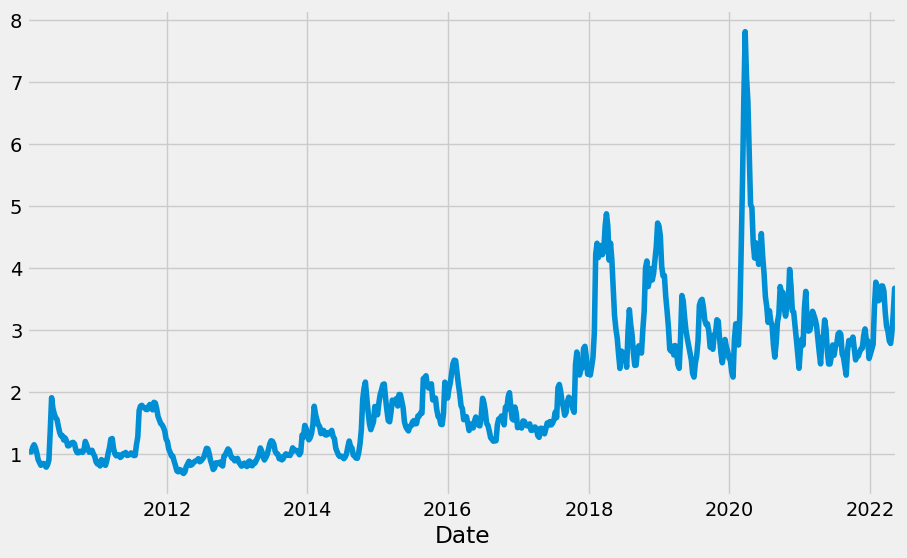

In [24]:
# quite a lot of variance in teh ATR
weekly_atr.iloc[0,:].plot()

In [25]:
weekly_atr.T.describe()

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DIS,GS,HD,HON,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT
count,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000
mean,2.030120,1.723797,2.723452,1.043934,4.254814,2.366847,1.610263,0.560622,0.504616,1.817493,4.046274,2.467327,1.843981,1.827452,0.727387,1.372694,1.477246,1.831291,0.840201,1.860915,1.269903,1.123243,2.791371,1.565337,3.398222,0.551639,1.934723,1.014112,1.229132
std,1.098202,1.319316,1.677894,1.221280,3.717874,1.443563,0.844378,0.349076,0.300507,1.304350,2.157083,2.378378,1.411365,0.608366,0.520211,0.884734,1.063113,1.446662,0.481483,2.169755,1.099506,0.787728,2.323825,1.023269,3.224640,0.249903,1.865854,0.403331,0.813038
min,0.684908,0.628396,0.601461,0.108684,0.806385,0.804171,0.599231,0.202967,0.190468,0.467461,1.650760,0.334001,0.488258,0.899934,0.186480,0.367798,0.535413,0.506090,0.264323,0.284980,0.216053,0.416508,0.417264,0.494072,0.559746,0.182068,0.272104,0.355101,0.412871
25%,1.097295,0.927354,1.235460,0.320071,1.492936,1.298918,1.047032,0.304776,0.324684,0.906341,2.556219,0.798545,0.871423,1.429237,0.360723,0.750248,0.730902,0.836123,0.497033,0.517461,0.481516,0.651827,1.254266,0.807048,1.020571,0.390506,0.630264,0.694351,0.697036
50%,1.678250,1.181997,2.490552,0.510352,2.255004,1.705331,1.319059,0.405378,0.414794,1.330970,3.405349,1.554037,1.248947,1.709750,0.489551,1.097985,1.049667,1.266547,0.704002,0.821527,0.844953,0.851022,1.655500,1.177821,2.016547,0.504764,1.085840,1.029365,0.901415
75%,2.738633,1.889414,3.700134,1.054587,7.196728,3.011987,1.940553,0.762869,0.584511,2.310774,4.398638,3.236890,2.437299,2.081269,1.034512,1.862116,1.850688,2.499896,1.075112,2.287626,1.573096,1.347544,3.567063,1.966596,5.269446,0.661880,2.640079,1.238591,1.544987
max,7.818706,8.534326,11.428007,5.847725,22.202176,6.946222,5.822203,2.437697,2.709318,8.119647,12.657728,14.735106,10.609191,5.868220,3.779690,6.552674,7.439126,12.231789,3.530166,10.139320,6.315017,6.551033,12.118897,7.429638,20.149962,2.354479,11.806200,3.153686,6.314879


In [26]:
# now we actually do some machine learning...

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from datetime import datetime

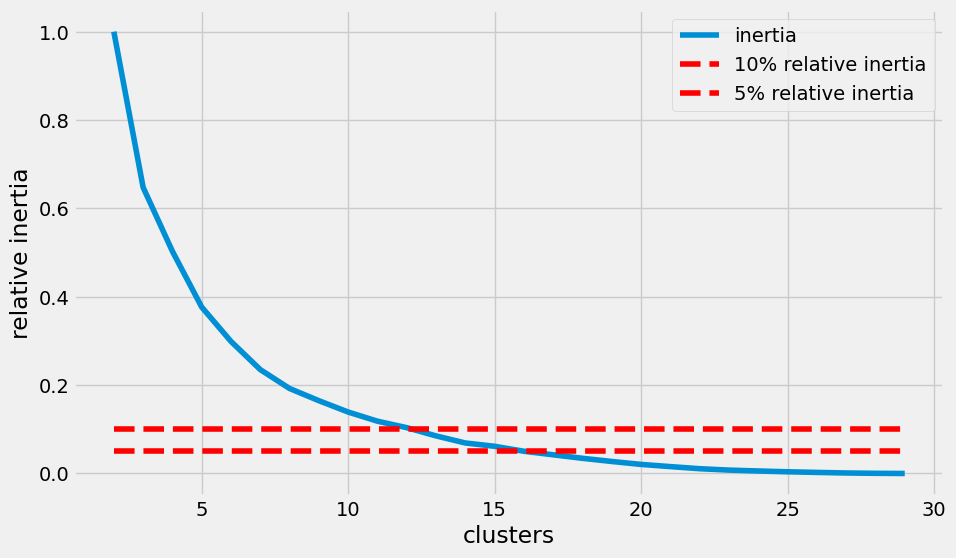

In [27]:
# How do we choose K?  We have 29 stocks - so it'd be crazy to have K = 29
# as everythign would be a unique point

# why are we calling this "intertia?"

n_clusters = range(2, 30)
inertia = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(weekly_atr)
    inertia.append(kmeans.inertia_)

plt.plot(n_clusters, np.divide(inertia,inertia[0]))
plt.hlines(0.1, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
plt.hlines(0.05, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
plt.xlabel('clusters')
plt.ylabel('relative inertia')
plt.legend(['inertia', '10% relative inertia', '5% relative inertia']);

In [28]:
# So we're landing on K=15 for a good number of clusters

model = Pipeline([
    ('normalisation', MinMaxScaler()),
    ('cluster', KMeans(n_clusters = 15))
])

model.fit(weekly_atr)

labels = model.predict(weekly_atr)

labels

array([14,  5,  6,  9,  7, 10, 14,  2,  2,  5,  4, 12,  5,  3,  2, 13, 13,
        5,  2,  0,  9, 13,  8,  5,  1,  2,  0, 11, 13], dtype=int32)

In [29]:
labels.shape

(29,)

In [30]:
# so we now have each stock, labeled with a cluster

In [31]:
weekly_ret.mean(axis=1)

MMM     0.001821
AXP     0.003270
AMGN    0.003269
AAPL    0.005627
BA      0.003214
CAT     0.003292
CVX     0.002666
CSCO    0.002073
KO      0.002227
DIS     0.002672
GS      0.002066
HD      0.004687
HON     0.003404
IBM     0.001294
INTC    0.002433
JNJ     0.002405
JPM     0.002857
MCD     0.003009
MRK     0.002503
MSFT    0.004294
NKE     0.003876
PG      0.002220
CRM     0.004452
TRV     0.002900
UNH     0.005154
VZ      0.002012
V       0.004196
WBA     0.001471
WMT     0.002155
dtype: float64

In [32]:
companies = stock_atr.columns

companies_name = dow_company_name
companies_name.remove('Dow')

df = pd.DataFrame({'Cluster': labels,
                    'Companies Name': companies_name,
                    'Companies': companies,
                    'ATR': weekly_atr.mean(axis=1),
                    'CHG': weekly_ret.mean(axis=1)}
                  ).sort_values(by=['Cluster'], axis = 0)

df = df.reset_index(drop=True)
df

,Cluster,Companies Name,Companies,ATR,CHG
0,0,Microsoft,MSFT,1.860915,0.004294
1,0,Visa,V,1.934723,0.004196
2,1,UnitedHealth Group,UNH,3.398222,0.005154
3,2,Verizon,VZ,0.551639,0.002012
4,2,Cisco,CSCO,0.560622,0.002073
5,2,Intel,INTC,0.727387,0.002433
6,2,Merck,MRK,0.840201,0.002503
7,2,Coca-Cola,KO,0.504616,0.002227
8,3,IBM,IBM,1.827452,0.001294
9,4,Goldman Sachs,GS,4.046274,0.002066


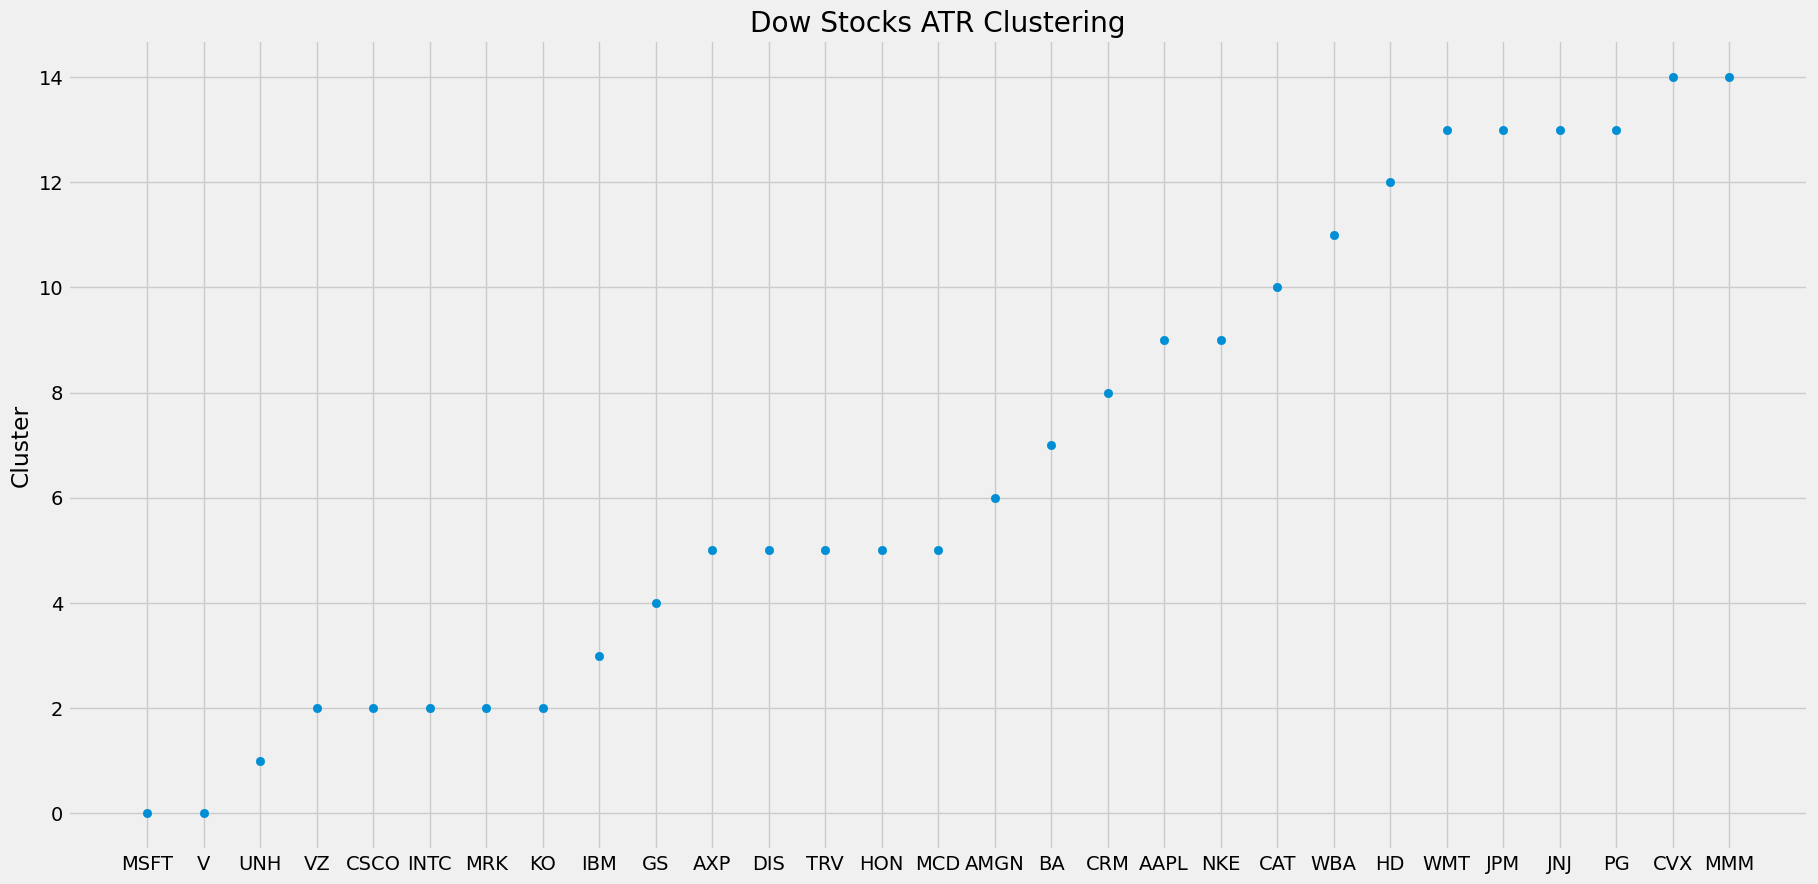

In [33]:
# So here, we've been able to identify companies that have similar volatility characteristics
# and grouped them together!

# now plot it nicely:



plt.figure(figsize=(20,10))
plt.scatter(df.Companies, df.Cluster)
# plt.xlabel('Stocks')
plt.ylabel('Cluster')
plt.title('Dow Stocks ATR Clustering');



In [34]:
model.get_params()


{'memory': None,
 'steps': [('normalisation', MinMaxScaler()),
  ('cluster', KMeans(n_clusters=15))],
 'verbose': False,
 'normalisation': MinMaxScaler(),
 'cluster': KMeans(n_clusters=15),
 'normalisation__clip': False,
 'normalisation__copy': True,
 'normalisation__feature_range': (0, 1),
 'cluster__algorithm': 'lloyd',
 'cluster__copy_x': True,
 'cluster__init': 'k-means++',
 'cluster__max_iter': 300,
 'cluster__n_clusters': 15,
 'cluster__n_init': 'warn',
 'cluster__random_state': None,
 'cluster__tol': 0.0001,
 'cluster__verbose': 0}

In [35]:

model['cluster'].cluster_centers_


array([[0.07883007, 0.07883007, 0.07883007, ..., 0.60018781, 0.5812101 ,
        0.58223624],
       [0.1876149 , 0.1876149 , 0.1876149 , ..., 1.        , 1.        ,
        1.        ],
       [0.051575  , 0.051575  , 0.051575  , ..., 0.02273082, 0.03193277,
        0.03648666],
       ...,
       [0.05053299, 0.05053299, 0.05053299, ..., 0.70915111, 0.78091557,
        0.78697041],
       [0.13393747, 0.13393747, 0.13393747, ..., 0.17224196, 0.20004674,
        0.21632277],
       [0.17625566, 0.17625566, 0.17625566, ..., 0.27108886, 0.27688379,
        0.27906885]])

In [36]:

model['cluster'].cluster_centers_.shape

# Save locally to be used in SOM
df.to_csv('./cluster_new.csv')



In [37]:
#### Self Organising Maps!

%pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10589 sha256=6909608ef6a17d5fd0c0e1f82271c6887e6caf57972d4f5277f2ec96a0beb12d
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom


In [38]:
import pandas as pd
import numpy as np
import random

from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

random.seed(2022)
np.random.seed(2022)

df = pd.read_csv('./cluster_new.csv', index_col =0)
df

,Cluster,Companies Name,Companies,ATR,CHG
0,0,Microsoft,MSFT,1.860915,0.004294
1,0,Visa,V,1.934723,0.004196
2,1,UnitedHealth Group,UNH,3.398222,0.005154
3,2,Verizon,VZ,0.551639,0.002012
4,2,Cisco,CSCO,0.560622,0.002073
5,2,Intel,INTC,0.727387,0.002433
6,2,Merck,MRK,0.840201,0.002503
7,2,Coca-Cola,KO,0.504616,0.002227
8,3,IBM,IBM,1.827452,0.001294
9,4,Goldman Sachs,GS,4.046274,0.002066


In [39]:
X = df[['ATR', 'CHG']]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[0.36166058, 0.69247254],
       [0.38134154, 0.66990553],
       [0.77158749, 0.89082986],
       [0.01253873, 0.16570193],
       [0.01493415, 0.17982974],
       [0.05940247, 0.26298085],
       [0.08948454, 0.27920037],
       [0.        , 0.2154934 ],
       [0.35273766, 0.        ],
       [0.94439214, 0.17813538],
       [0.32509777, 0.45599264],
       [0.35008206, 0.31816335],
       [0.28284404, 0.37064958],
       [0.35714512, 0.48706498],
       [0.35376124, 0.39583943],
       [0.59165824, 0.45579553],
       [1.        , 0.44308817],
       [0.609769  , 0.72887315],
       [0.14381049, 1.        ],
       [0.20406575, 0.59587851],
       [0.4965686 , 0.46114524],
       [0.13585829, 0.04103213],
       [0.52336181, 0.78322071],
       [0.19319397, 0.19870063],
       [0.25935415, 0.3606743 ],
       [0.23147519, 0.25656426],
       [0.16495844, 0.21374153],
       [0.29482345, 0.31660278],
       [0.40677947, 0.12162373]])

In [46]:
# map with 15 cells by 15.  Pretty arbitrary
# there's a heuristic that you should have x & y = sqrt(number of items)
# So he starts off with x, y = 5.  But then changes to x, y = 15 for more
# granularity
som = MiniSom(5, 5, 2, learning_rate = 0.5, sigma = 5, random_seed = 42)

som.random_weights_init(X)

som.train_batch(X, 10000, verbose = True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.13532396175784844


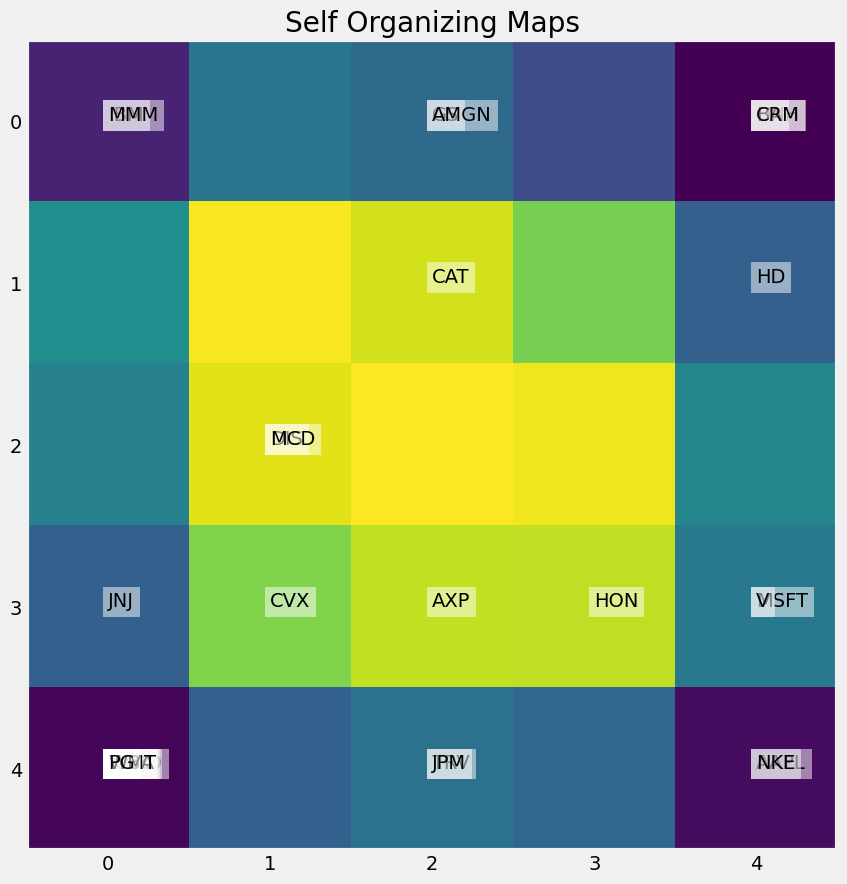

In [47]:


# Plot SOM
plt.figure(figsize=(20, 10))
for ix in range(len(X)):
    winner = som.winner(X[ix])
    plt.text(winner[0], winner[1], df.Companies[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.imshow(som.distance_map())
plt.grid(False)
plt.title('Self Organizing Maps');



In [48]:
# So are these findings consistent with what we saw in KNN?
# Here we output basically the 'cell' that each stock is in.  "Related stocks"
# should be close by, unrelated stocks should be far apart

# List the corresponding companies
for ix in range(len(X)):
    winner = som.winner(X[ix])
    print(winner[0], winner[1], df['Companies Name'][ix])

4 3 Microsoft
4 3 Visa
4 0 UnitedHealth Group
0 4 Verizon
0 4 Cisco
0 4 Intel
0 4 Merck
0 4 Coca-Cola
0 0 IBM
2 0 Goldman Sachs
2 3 American Express
1 2 Disney
2 4 Travelers
3 3 Honeywell
1 2 McDonald's
2 0 Amgen
4 0 Boeing
4 0 Salesforce
4 4 Apple
4 4 Nike
2 1 Caterpillar
0 4 Walgreens Boots Alliance
4 1 Home Depot
0 4 Walmart
2 4 JPMorgan Chase
0 3 Johnson & Johnson
0 4 Procter & Gamble
1 3 Chevron
0 0 3M


In [ ]:
# Remember from KNN earlier we saw this cluster:

# 	2 	Verizon 	VZ 	0.551639 	0.002012
# 	2 	Cisco 	CSCO 	0.560622 	0.002073
# 	2 	Intel 	INTC 	0.727387 	0.002433
# 	2 	Merck 	MRK 	0.840201 	0.002503
# 	2 	Coca-Cola 	KO 	0.504616 	0.002227

# Well, SOM has put these stocks in the same cell 0, 4
# (with the exception that it also puts in IBM!)

# 0 4 Verizon
# 0 4 Cisco
# 0 4 Intel
# 0 4 Merck
# 0 4 Coca-Cola
# 0 0 IBM


# He then goes back to the original point where he trains the minisom
# but this time with x, y = 15 not 5

# But the argument is that at 15x15, each stock is more or less
# in its own cell - meaning, we haven't actually clustered anything together
# So 5x5 is probably better...

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.020683715819187612


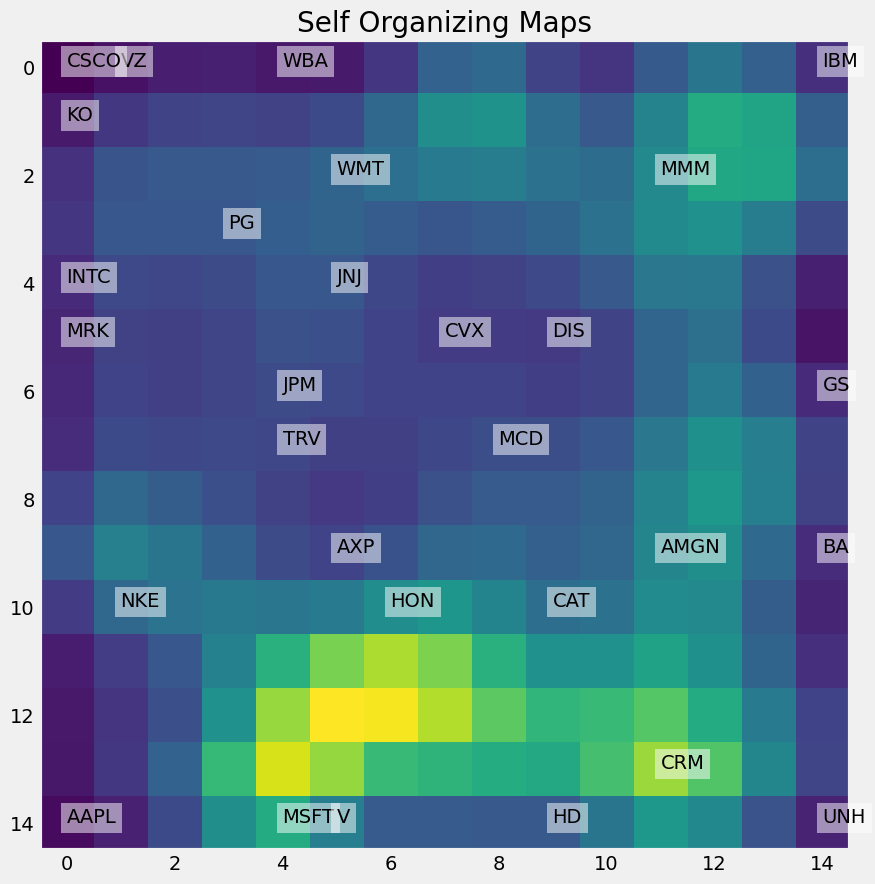

In [50]:
som = MiniSom(15, 15, 2, learning_rate = 0.5, sigma = 5, random_seed = 42)

som.random_weights_init(X)

som.train_batch(X, 10000, verbose = True)

# Plot SOM
plt.figure(figsize=(20, 10))
for ix in range(len(X)):
    winner = som.winner(X[ix])
    plt.text(winner[0], winner[1], df.Companies[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.imshow(som.distance_map())
plt.grid(False)
plt.title('Self Organizing Maps');